In [1]:
import numpy as np
import cv2
import os
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import keras.optimizers as optimizers
import keras
from keras import backend as K
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
K.clear_session()

In [3]:
import tensorflow as tf
from keras.backend import tensorflow_backend

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

In [4]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

In [5]:
INPUT_WIDTH = 140 #vgg12:224  inceptionv3:299
INPUT_HEIGHT = 140
BATCH_SIZE = 64
EPOCHS = 300
STEPS = 10
CATEGORY = 4

OK_DIR1 = "/home/ubuntu/deeplearning/car/data/ok_body_only"
OK_DIR2 = "/home/ubuntu/deeplearning/car/data/ok_other"
NG_DIR1 = "/home/ubuntu/deeplearning/car/data/ng_kizu"
NG_DIR2 = "/home/ubuntu/deeplearning/car/data/ng_hekomi"

In [6]:
def load_image(dir_name, label):
    x = []
    y = []
    files = os.listdir(dir_name)
    for file in files:
        img = cv2.imread(os.path.join(dir_name, file))
#        img = cv2.imread(os.path.join(dir_name, file), 0)
        # リサイズ
        img = cv2.resize(img, (INPUT_WIDTH, INPUT_HEIGHT))
        # 正規化
#        img = (img - np.mean(img)) / np.std(img)

        img_array = np.array(img_to_array(img))
        x.append(img_array)
        if label == 0:
            y.append([1, 0, 0, 0]) # OK1ラベル
        elif label == 1:
            y.append([0, 1, 0, 0]) # OK1ラベル
        elif label == 2:
            y.append([0, 0, 1, 0]) # NG1ラベル
        else:
            y.append([0, 0, 0, 1]) # NG2ラベル
    
    return (x, y)

In [7]:
x_train = []
y_train = []
x_test = []
y_test = []

# OK画像を読み込む
x_ok1, y_ok1 = load_image(OK_DIR1, 0)
x_ok2, y_ok2 = load_image(OK_DIR2, 1)
x_ng1, y_ng1 = load_image(NG_DIR1, 2)
x_ng2, y_ng2 = load_image(NG_DIR2, 3)

x_train = x_ok1 + x_ok2 + x_ng1 + x_ng2
y_train = y_ok1 + y_ok2 + y_ng1 + y_ng2
    
# np配列化
x_train = np.array(x_train)
y_train = np.array(y_train)

# kerasは0～1しか受け付けない
x_train = x_train / 255
y_train = y_train / 255

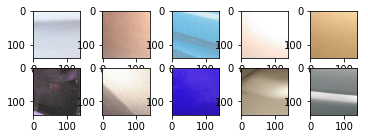

In [8]:
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.imshow(array_to_img(x_train[i]))
    plt.gray()
plt.show() 

In [9]:
# 訓練データとテストデータを分割
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=None)

In [10]:
# モデルを作る
def inceptionV3fc_model():
    input_tensor = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))
    inceptionv3 = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
    
    # 全結合１
    top_model = Sequential()
    top_model.add(Flatten(input_shape=inceptionv3.output_shape[1:]))
    top_model.add(Dense(128, name="dense1"))
    top_model.add(Activation("relu"))
    top_model.add(Dropout(0.5))
    
    # 全結合２　２層にしてみる
#    top_model.add(Dense(64, name="dense2"))
#    top_model.add(Activation("relu"))
#    top_model.add(Dropout(0.5))
    
    # 出力
    top_model.add(Dense(CATEGORY, name="output"))
    top_model.add(Activation("softmax"))
    
    # 接続
    model = Model(inputs=inceptionv3.input, outputs=top_model(inceptionv3.output))
    
    # 元の特徴抽出部分は更新しない
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True
        
    return model

In [11]:
model = inceptionV3fc_model()

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 140, 140, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 69, 69, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 69, 69, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 69, 69, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [13]:
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', 
              # optimizer='rmsprop',
               optimizer='adam',
#              optimizer=optimizers.SGD(),
              metrics=['accuracy'])

In [14]:
train_gen = ImageDataGenerator(
#    rescale=1./255,
#    featurewise_center=False,
#    samplewise_center=False,
#    featurewise_std_normalization=False,
#    samplewise_std_normalization=False,
    rotation_range=180,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
#    zoom_range=[.8, 1],
#    channel_shift_range=30,
#    fill_mode='reflect'
)
test_gen = ImageDataGenerator()

In [15]:
# callback
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

In [16]:
history = model.fit_generator(train_gen.flow(x_train, 
                                  y_train, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True
                                 ), 
                    steps_per_epoch=STEPS, 
                    epochs=EPOCHS,
                    #callbacks=[es_cb],
                    validation_data=(x_test, y_test))

Epoch 1/300
10/10 [==============================] - 52s - loss: 0.0089 - acc: 0.4513 - val_loss: 0.0199 - val_acc: 0.4922
Epoch 2/300
10/10 [==============================] - 2s - loss: 0.0032 - acc: 0.7126 - val_loss: 0.0102 - val_acc: 0.6016
Epoch 3/300
10/10 [==============================] - 2s - loss: 0.0022 - acc: 0.8055 - val_loss: 0.0182 - val_acc: 0.5781
Epoch 4/300
10/10 [==============================] - 2s - loss: 0.0014 - acc: 0.8748 - val_loss: 0.0145 - val_acc: 0.6016
Epoch 5/300
10/10 [==============================] - 2s - loss: 0.0011 - acc: 0.8976 - val_loss: 0.0125 - val_acc: 0.6094
Epoch 6/300
10/10 [==============================] - 2s - loss: 0.0012 - acc: 0.9016 - val_loss: 0.0104 - val_acc: 0.6641
Epoch 7/300
10/10 [==============================] - 2s - loss: 8.4301e-04 - acc: 0.9386 - val_loss: 0.0122 - val_acc: 0.5937
Epoch 8/300
10/10 [==============================] - 2s - loss: 0.0010 - acc: 0.9149 - val_loss: 0.0092 - val_acc: 0.6484 - acc: 0
Epoch 9/30

10/10 [==============================] - 2s - loss: 2.4317e-04 - acc: 0.9898 - val_loss: 0.0079 - val_acc: 0.7187
Epoch 66/300
10/10 [==============================] - 2s - loss: 1.9830e-04 - acc: 0.9890 - val_loss: 0.0067 - val_acc: 0.7422
Epoch 67/300
10/10 [==============================] - 2s - loss: 2.6409e-04 - acc: 0.9779 - val_loss: 0.0059 - val_acc: 0.7500
Epoch 68/300
10/10 [==============================] - 2s - loss: 1.6414e-04 - acc: 0.9890 - val_loss: 0.0068 - val_acc: 0.7266
Epoch 69/300
10/10 [==============================] - 2s - loss: 5.1191e-04 - acc: 0.9685 - val_loss: 0.0108 - val_acc: 0.6953
Epoch 70/300
10/10 [==============================] - 2s - loss: 3.5886e-04 - acc: 0.9850 - val_loss: 0.0088 - val_acc: 0.7187
Epoch 71/300
10/10 [==============================] - 2s - loss: 9.1180e-05 - acc: 0.9969 - val_loss: 0.0062 - val_acc: 0.7266
Epoch 72/300
10/10 [==============================] - 2s - loss: 2.1730e-04 - acc: 0.9858 - val_loss: 0.0067 - val_acc: 0.72

10/10 [==============================] - 2s - loss: 2.1898e-04 - acc: 0.9882 - val_loss: 0.0058 - val_acc: 0.7656
Epoch 130/300
10/10 [==============================] - 2s - loss: 3.4796e-04 - acc: 0.9858 - val_loss: 0.0066 - val_acc: 0.7578
Epoch 131/300
10/10 [==============================] - 2s - loss: 1.3402e-04 - acc: 0.9882 - val_loss: 0.0076 - val_acc: 0.7812
Epoch 132/300
10/10 [==============================] - 2s - loss: 3.0944e-04 - acc: 0.9787 - val_loss: 0.0073 - val_acc: 0.7500
Epoch 133/300
10/10 [==============================] - 2s - loss: 1.7989e-04 - acc: 0.9842 - val_loss: 0.0114 - val_acc: 0.6562
Epoch 134/300
10/10 [==============================] - 2s - loss: 2.4087e-04 - acc: 0.9843 - val_loss: 0.0081 - val_acc: 0.7266
Epoch 135/300
10/10 [==============================] - 2s - loss: 7.9651e-05 - acc: 0.9961 - val_loss: 0.0066 - val_acc: 0.7656
Epoch 136/300
10/10 [==============================] - 2s - loss: 1.3895e-04 - acc: 0.9906 - val_loss: 0.0062 - val_ac

10/10 [==============================] - 2s - loss: 1.2833e-04 - acc: 0.9953 - val_loss: 0.0074 - val_acc: 0.7500
Epoch 194/300
10/10 [==============================] - 2s - loss: 3.7843e-05 - acc: 0.9961 - val_loss: 0.0069 - val_acc: 0.7344
Epoch 195/300
10/10 [==============================] - 2s - loss: 2.3810e-04 - acc: 0.9897 - val_loss: 0.0068 - val_acc: 0.7422
Epoch 196/300
10/10 [==============================] - 2s - loss: 1.4584e-04 - acc: 0.9906 - val_loss: 0.0071 - val_acc: 0.7109
Epoch 197/300
10/10 [==============================] - 2s - loss: 5.3082e-05 - acc: 0.9969 - val_loss: 0.0079 - val_acc: 0.6875
Epoch 198/300
10/10 [==============================] - 2s - loss: 1.3068e-04 - acc: 0.9890 - val_loss: 0.0082 - val_acc: 0.6641
Epoch 199/300
10/10 [==============================] - 2s - loss: 2.0901e-04 - acc: 0.9850 - val_loss: 0.0073 - val_acc: 0.6641
Epoch 200/300
10/10 [==============================] - 2s - loss: 3.4977e-05 - acc: 0.9961 - val_loss: 0.0065 - val_ac

10/10 [==============================] - 2s - loss: 3.0302e-04 - acc: 0.9858 - val_loss: 0.0073 - val_acc: 0.7422
Epoch 258/300
10/10 [==============================] - 2s - loss: 1.4139e-04 - acc: 0.9969 - val_loss: 0.0073 - val_acc: 0.7500
Epoch 259/300
10/10 [==============================] - 2s - loss: 1.2475e-04 - acc: 0.9969 - val_loss: 0.0074 - val_acc: 0.7500
Epoch 260/300
10/10 [==============================] - 2s - loss: 8.2129e-05 - acc: 0.9937 - val_loss: 0.0076 - val_acc: 0.7656
Epoch 261/300
10/10 [==============================] - 2s - loss: 2.9616e-04 - acc: 0.9819 - val_loss: 0.0081 - val_acc: 0.7656
Epoch 262/300
10/10 [==============================] - 2s - loss: 7.3887e-05 - acc: 0.9929 - val_loss: 0.0083 - val_acc: 0.7656
Epoch 263/300
10/10 [==============================] - 2s - loss: 7.5974e-05 - acc: 0.9929 - val_loss: 0.0086 - val_acc: 0.7578
Epoch 264/300
10/10 [==============================] - 2s - loss: 1.6556e-04 - acc: 0.9874 - val_loss: 0.0084 - val_ac

In [17]:
def predict_message(predict):
    indice = np.argmax(predict)
    if indice in {0, 1}:
        print("ok (%s)" % str(predict[0] + predict[1]))
    elif indice in {2}:
        print("ng kizu (%s)" % str(predict[indice]))
    elif indice in {3}:
        print("ng hekomi (%s)" % str(predict[indice]))

In [18]:
predicts = model.predict(x_test)

ok (0.99982)


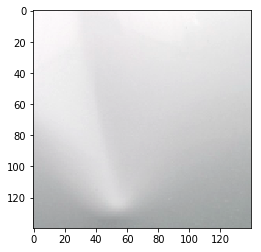

In [19]:
plt.imshow(array_to_img(x_test[0]))
predict_message(predicts[0])

ng hekomi (1.0)


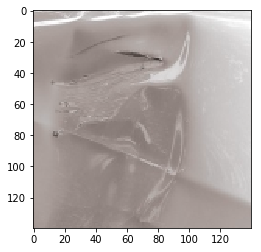

In [20]:
plt.imshow(array_to_img(x_test[1]))
predict_message(predicts[1])

ng kizu (1.0)


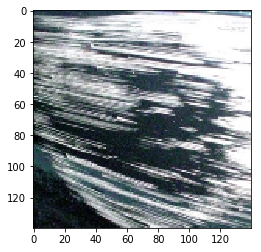

In [21]:
plt.imshow(array_to_img(x_test[2]))
predict_message(predicts[2])

ng hekomi (0.991937)


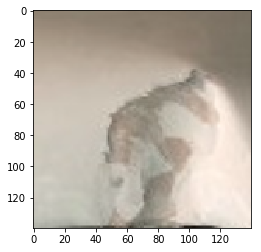

In [22]:
plt.imshow(array_to_img(x_test[3]))
predict_message(predicts[3])

ng kizu (1.0)


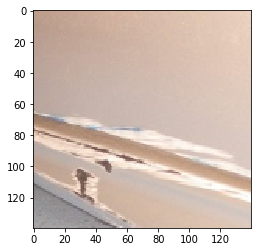

In [23]:
plt.imshow(array_to_img(x_test[4]))
predict_message(predicts[4])

ng kizu (1.0)


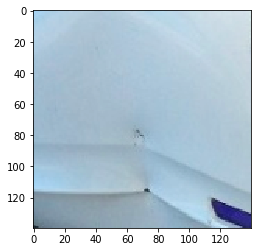

In [24]:
plt.imshow(array_to_img(x_test[5]))
predict_message(predicts[5])

In [25]:
json_string = model.to_json()
open(os.path.join('dragon_cnn_model.json'), 'w').write(json_string)

147359

In [26]:
model.save_weights(os.path.join('dragon_cnn_model_weights.hdf5'))

In [27]:
def predict_ok_ng(x, y):
    correct = 0
    wrong = 0
    predicts = model.predict(x)
    for i in range(len(x)):
        indice = np.argmax(predicts[i])
        # ok
        if y[i][0] == 1 or y[i][1]:
            if indice in {0, 1}:
                correct += 1
            else:
                wrong += 1
        else:
            if indice in {2, 3}:
                correct += 1
            else:
                wrong += 1
    
    print("correct: %s / wrong: %s / acc: %s" % (str(correct), str(wrong), str(correct / (correct + wrong))))

In [28]:
predict_ok_ng(x_test, y_test)

correct: 100 / wrong: 28 / acc: 0.78125


In [29]:
# 学習を可視化
with open("history.pickle", mode='wb') as f:
    pickle.dump(history.history, f)

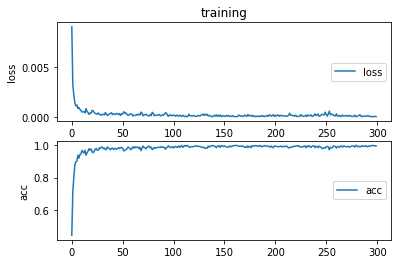

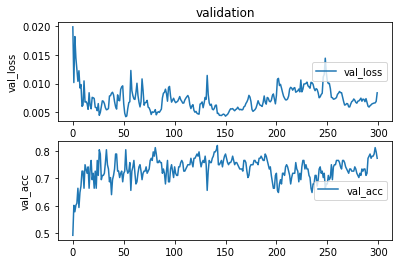

In [30]:
with open('history.pickle', mode='rb') as f:
    history = pickle.load(f)

plt.subplot(2,1,1)
plt.plot(history['loss'], "-", label="loss",)
plt.title('training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center right')

plt.subplot(2,1,2)
plt.plot(history['acc'], "-", label="acc",)
plt.ylabel('acc')
plt.legend(loc='center right')

plt.show()

plt.subplot(2,1,1)
plt.plot(history['val_loss'], "-", label="val_loss")
plt.title('validation')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend(loc='center right')
plt.subplot(2,1,2)
plt.plot(history['val_acc'], "-", label="val_acc")
plt.ylabel('val_acc')
plt.legend(loc='center right')

plt.show()

In [31]:
K.clear_session()